# ORBIT Calibration

This notebook demonstrates how to use the ORBIT calibration method to estimate the fidelity of a quantum device. The ORBIT method is a variant of the randomized benchmarking protocol that uses a single qubit to estimate the fidelity of a multi-qubit device. The method is described in detail in this [paper](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.112.240504).

ORBIT consists in preparing an interleaved randomized benchmarking sequence (of fixed length), and then measuring the fidelity of the device by comparing the output of the interleaved sequence with the output of the reference sequence. The fidelity is then estimated as the probability of measuring the ground state of the qubit after the interleaved sequence. This estimation is then used as a cost function for a model-free optimizer to tune the parameters of the gate set as an interleaved element.

In this notebook, we show how to leverage our defined interface for `QuantumEnvironment` to perform ORBIT. 

In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit_experiments.library.randomized_benchmarking import InterleavedRB
from qiskit.quantum_info import Clifford, random_clifford, Operator
from q_env_config import q_env_config as gate_q_env_config, circuit_context
from quantumenvironment import QuantumEnvironment
from context_aware_quantum_environment import ContextAwareQuantumEnvironment
from orbit import ORBIT
import numpy as np
from typing import Callable

2024-05-21 13:42:37,850 - qm - INFO     - Starting session: bd4e475d-8f31-4593-847b-4898b91190b7
Circuit context


In [2]:
use_context = False
if use_context:
    q_env = ContextAwareQuantumEnvironment(
        gate_q_env_config, circuit_context, training_steps_per_gate=250
    )
else:
    q_env = QuantumEnvironment(gate_q_env_config)

Aer Backend created out of backend <qiskit_ibm_runtime.fake_provider.backends.nairobi.fake_nairobi.FakeNairobiV2 object at 0x3568ce910>


/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/qiskit_ibm_runtime/session.py:157: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(


In [3]:
num_qubits = 2
rb_length = 1
num_sequences = 3

In [4]:
lengths = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]
orbits = [ORBIT(rb_length, num_sequences, q_env) for rb_length in lengths]

In [5]:
x0 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0]
orbits[2].optimize(x0)

       message: Maximum number of function evaluations has been exceeded.
       success: False
        status: 1
           fun: 0.2723333333333334
             x: [-2.138e-05 -6.829e-06  1.398e-06  2.407e-05  2.118e-05
                  1.910e-04 -8.571e-06]
           nit: 477
          nfev: 1400
 final_simplex: (array([[-2.138e-05, -6.829e-06, ...,  1.910e-04,
                        -8.571e-06],
                       [-2.138e-05, -6.829e-06, ...,  1.910e-04,
                        -8.571e-06],
                       ...,
                       [-2.138e-05, -6.829e-06, ...,  1.910e-04,
                        -8.571e-06],
                       [-2.138e-05, -6.829e-06, ...,  1.910e-04,
                        -8.571e-06]]), array([ 2.723e-01,  2.777e-01,  2.923e-01,  2.927e-01,
                        2.930e-01,  3.010e-01,  3.040e-01,  3.103e-01]))

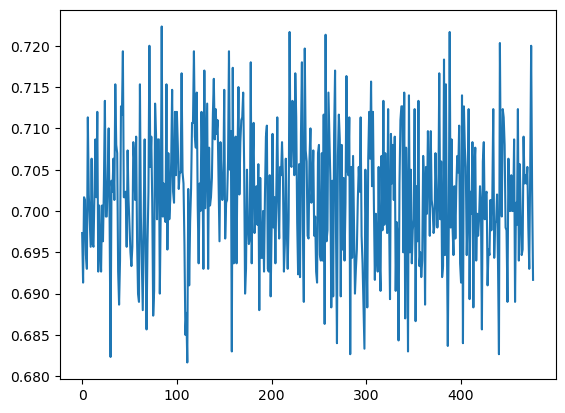

In [6]:
import matplotlib.pyplot as plt

plt.plot(orbits[2].fidelities)

In [6]:
# import warnings
#
# warnings.filterwarnings('error', category=RuntimeWarning)

# Your code here
fidelities = []
for orbit in orbits:
    fidelities.append(
        orbit.run_orbit_circuits(
            np.pi * np.array([0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5])
        )
    )

a = 0.681290628809264, b = 0.04342612580320373, c = 0.25483803527715104


/var/folders/y8/9zgwllj55dbbch4pxmg_g7jm0000gn/T/ipykernel_59396/87845210.py:8: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c


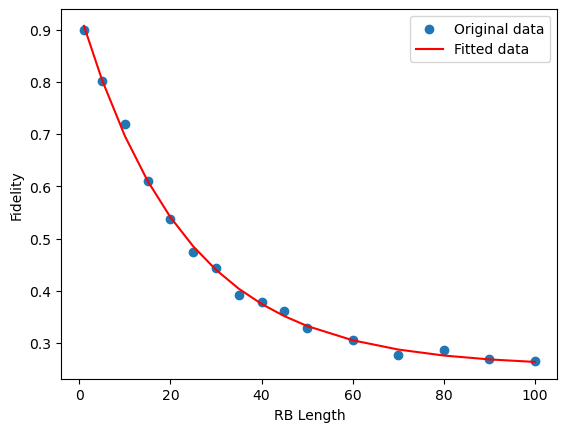

In [7]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt


# Define the form of the exponential decay function
def exp_decay(x, a, b, c):
    return a * np.exp(-b * x) + c


# Use curve_fit to fit the exp_decay function to your data
popt, pcov = curve_fit(exp_decay, lengths, fidelities)

# Print the optimal parameters a, b, c
print(f"a = {popt[0]}, b = {popt[1]}, c = {popt[2]}")

# Plot the original data (in blue) and the fitted data (in red)
plt.scatter(lengths, fidelities, marker="o", label="Original data")
plt.plot(lengths, exp_decay(np.array(lengths), *popt), "r", label="Fitted data")
plt.xlabel("RB Length")
plt.ylabel("Fidelity")
plt.legend()
plt.show()

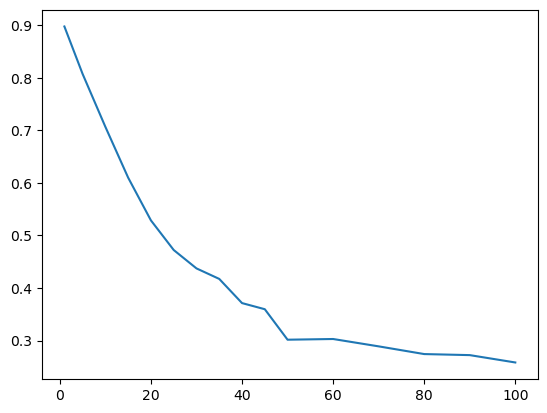

In [7]:
import matplotlib.pyplot as plt

plt.plot([orbit.rb_length for orbit in orbits], fidelities)

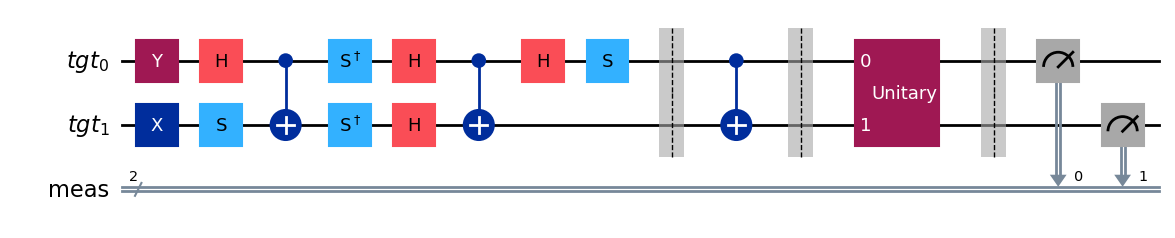

In [7]:
orbits[0].ref_circuits[0].draw("mpl")

In [8]:
orbits[0].ref_interleaved_circuits[0].draw("mpl")

AttributeError: 'ORBIT' object has no attribute 'ref_interleaved_circuits'

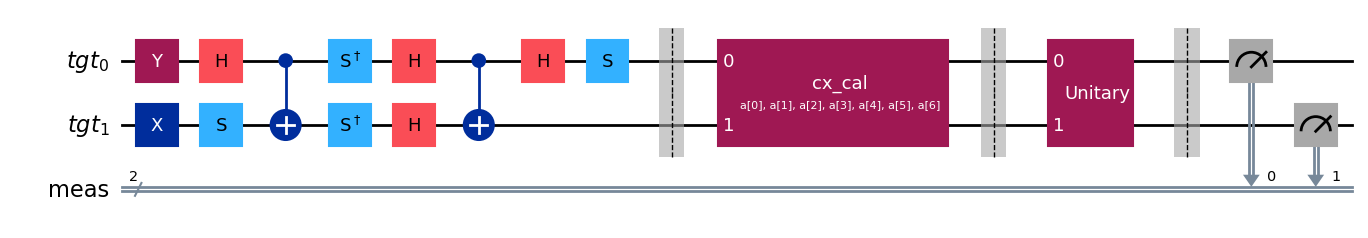

In [13]:
orbits[0].run_circuits[0].draw("mpl")

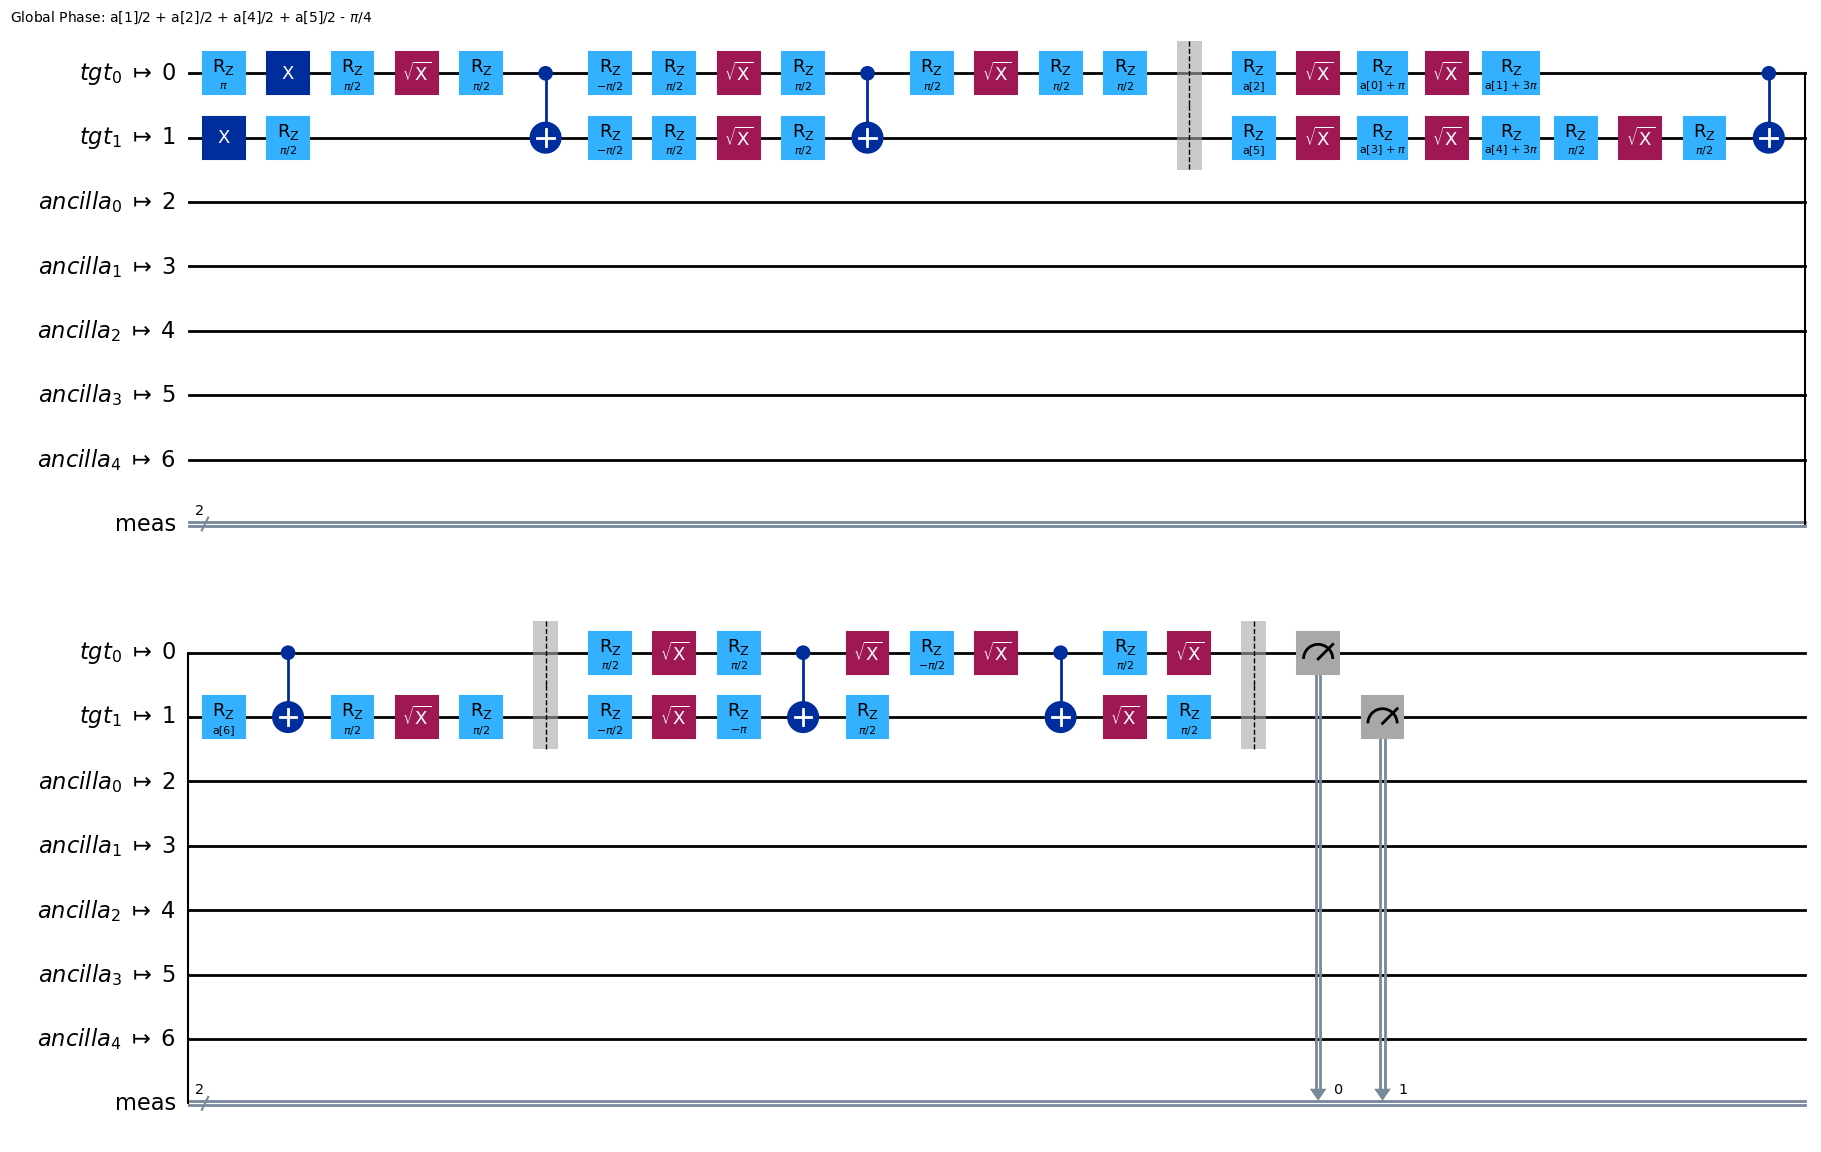

In [14]:
orbits[0].transpiled_circuits[0].draw("mpl")

In [17]:
Operator(
    orbits[3]
    .transpiled_circuits[0]
    .assign_parameters(
        np.pi * np.array([0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5]), inplace=False
    )
    .remove_final_measurements(inplace=False)
).draw("latex")

<IPython.core.display.Latex object>

In [11]:
exp = InterleavedRB(
    q_env.target.gate, q_env.physical_target_qubits, lengths=[2, 3, 4], num_samples=2
)

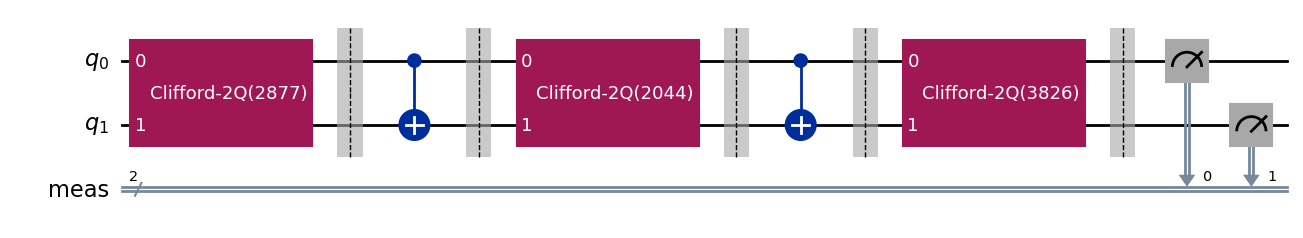

In [18]:
exp.circuits()[7].draw("mpl")

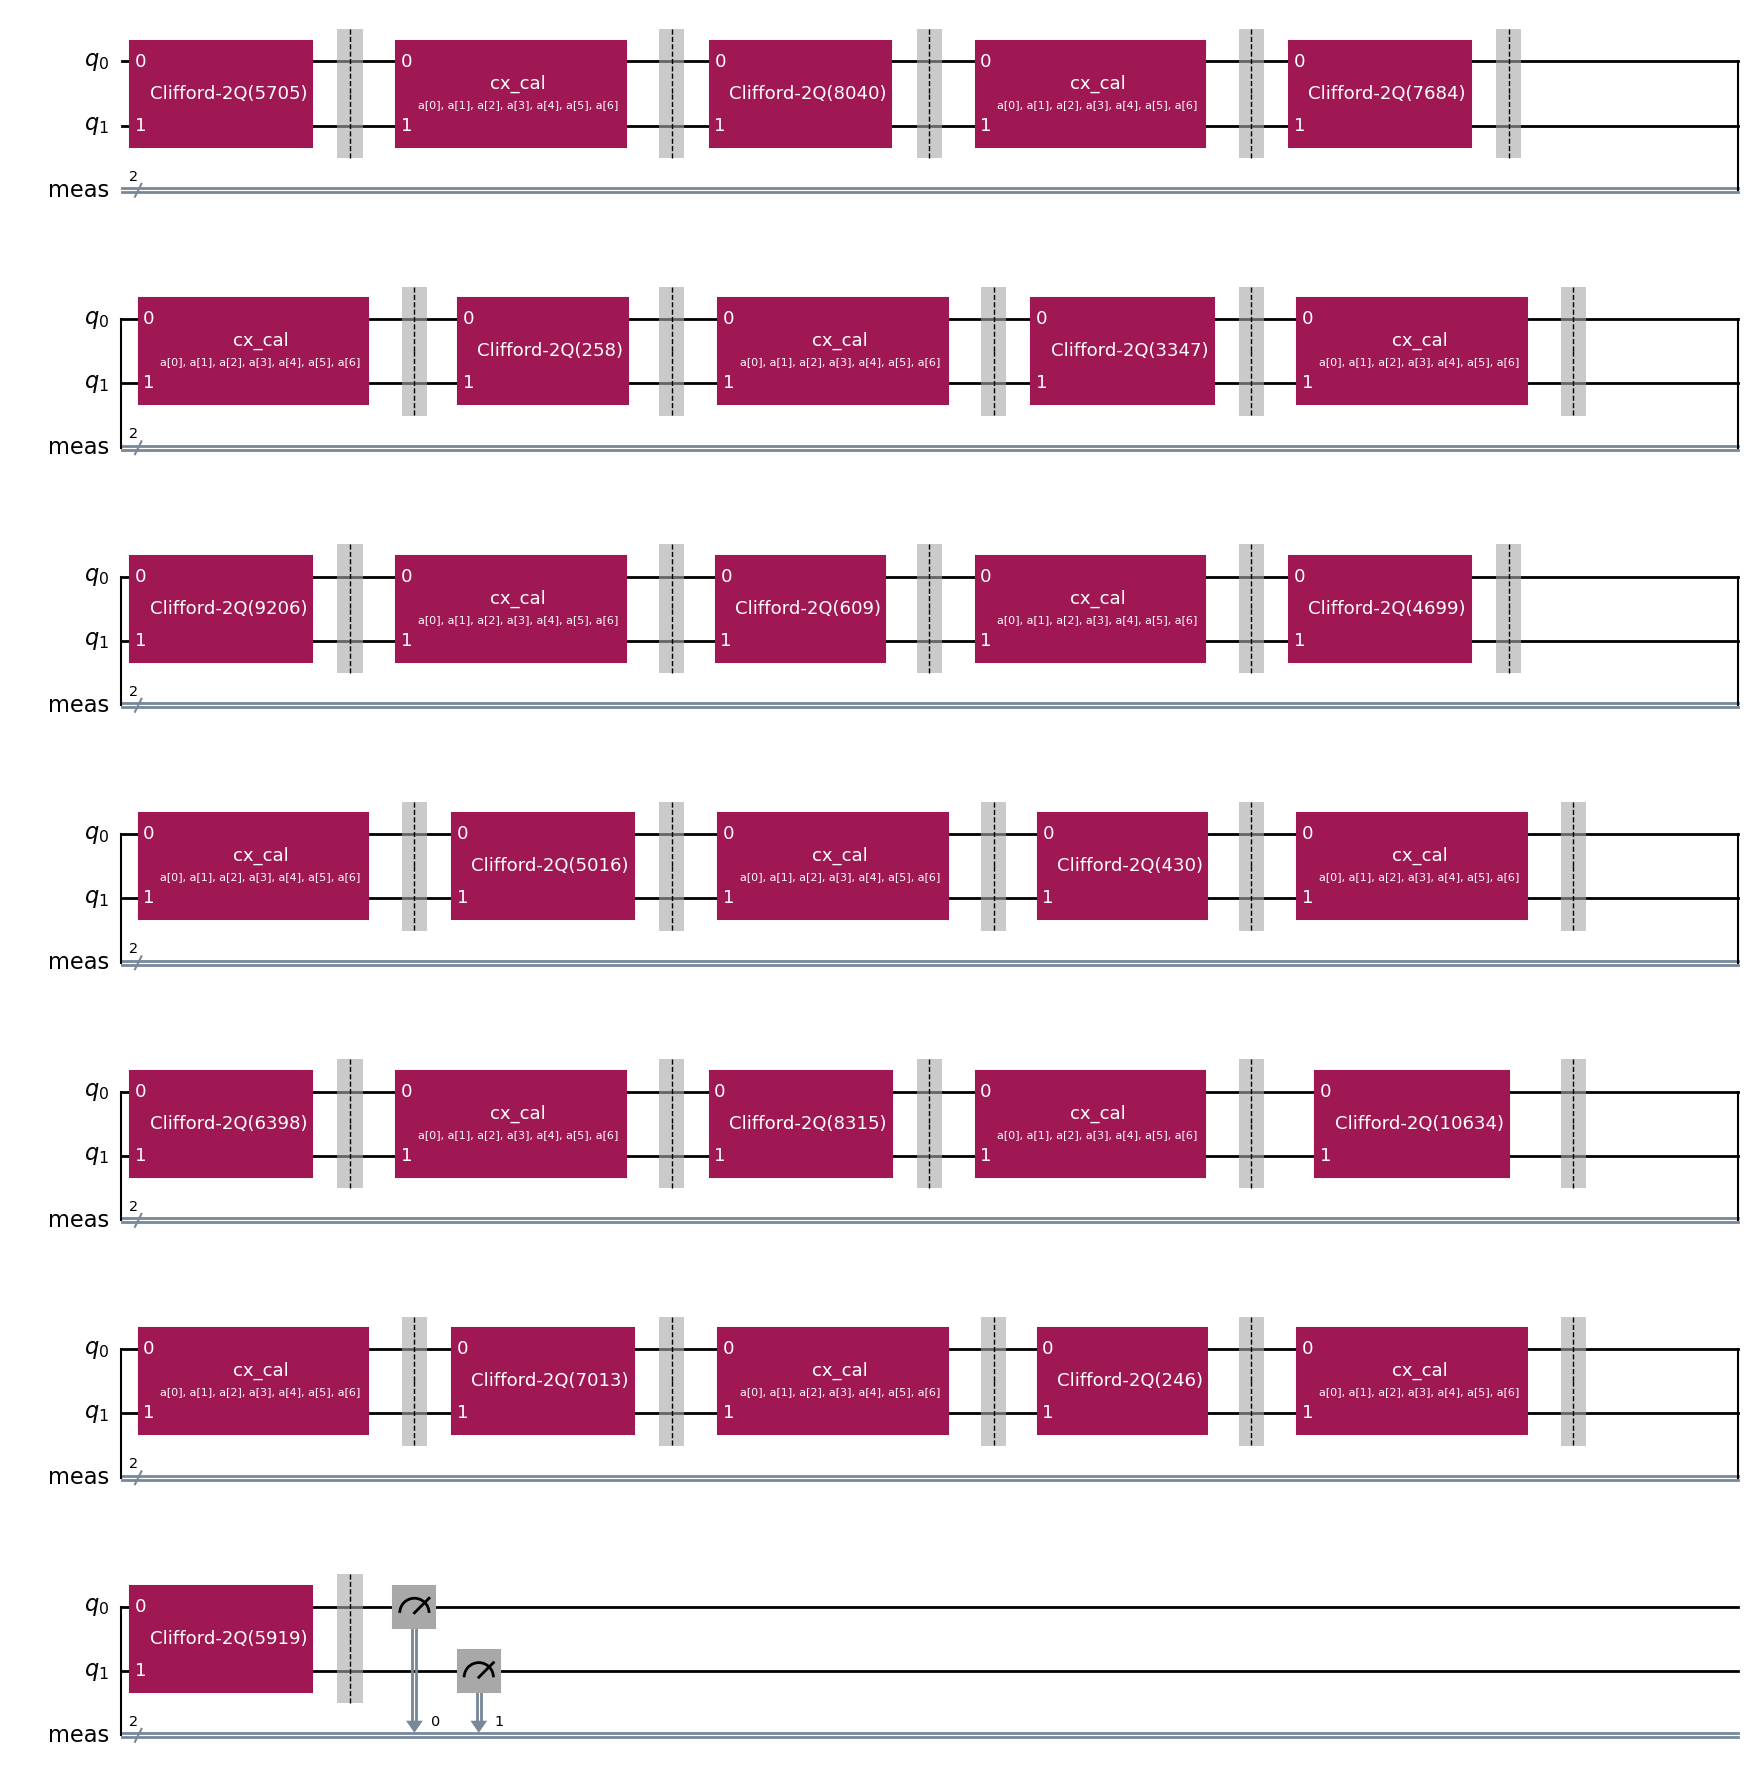

In [49]:
circ.draw("mpl")

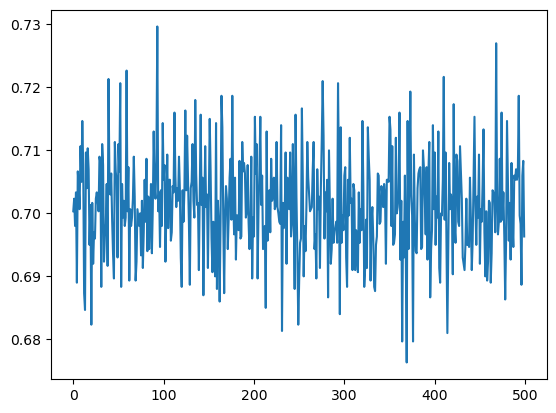

In [8]:
plt.plot(orbits[2].fidelities)